<a href="https://colab.research.google.com/github/parthsaxena1909/Image-Classifer-using-CIFRA10/blob/master/CNN_Keras_imageClassfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os 
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline 

if not os.path.isdir('models'):
  os.mkdir('models')

print('Tensorflow Version:', tf.__version__)
print('is using GPU?', tf.test.is_gpu_available())


Tensorflow Version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
is using GPU? False


In [2]:
def get_three_classess(x,y):
  indices_0, _ = np.where(y==0.)
  indices_1, _ = np.where(y==1.)
  indices_2, _ = np.where(y==2.)

  indices = np.concatenate([indices_0, indices_1, indices_2], axis = 0)

  x = x[indices]
  y = y[indices]

  count = x.shape[0]
  indices = np.random.choice(range(count), count , replace = False )

  x = x[indices]
  y= y[indices]

  y = tf.keras.utils.to_categorical(y)

  return x,y 
  



In [4]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train,y_train = get_three_classess(x_train,y_train)
x_test, y_test = get_three_classess(x_test,y_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


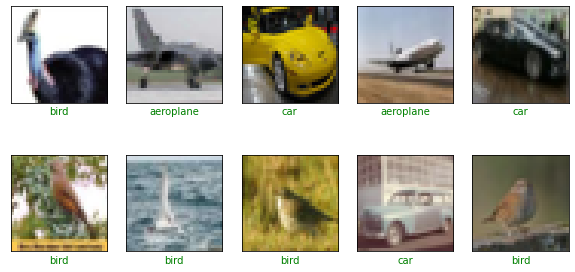

In [6]:
class_names = ['aeroplane','car','bird']
def show_random_examples(x,y,p):
  indices = np.random.choice(range(x.shape[0]), 10, replace = False)

  x=x[indices]
  y=y[indices]
  p=p[indices]
  plt.figure(figsize = (10,5))
  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])], color = col)
  plt.show()
show_random_examples(x_train,y_train,y_train)
                     


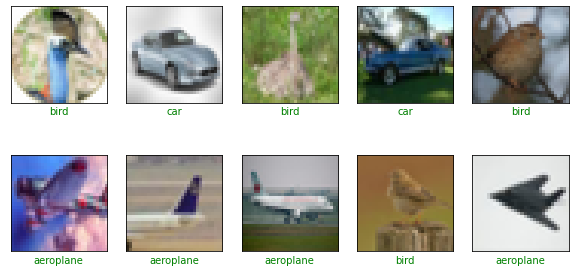

In [7]:
show_random_examples(x_test,y_test,y_test)

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input,Dense

def create_model():
  def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters,3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters,3,activation='relu',padding='valid'))
    model.add(MaxPooling2D(pool_size= 2))
    model.add(Dropout(0.5))
    return model

  model = tf.keras.models.Sequential()
  model.add(Input(shape=(32,32,3)))

  model = add_conv_block(model,32)
  model=  add_conv_block(model,64)
  model = add_conv_block(model,128)
  model.add(Flatten())
  model.add(Dense(3,activation='softmax'))

  model.compile(
      loss = 'categorical_crossentropy',
      optimizer= 'adam', metrics=['accuracy']
  )
  return model 
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [9]:
h = model.fit(
    x_train/255.,y_train,
    validation_data=(x_test/255.,y_test),
    epochs=10, batch_size = 128,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
               tf.keras.callbacks.ModelCheckpoint(
                   'models/model_{val_accuracy:.3f}.h5',
                   save_best_only=True, save_weights_only=False,
                   monitor = 'val_accuracy'
               )
    ]
)

Epoch 1/10
118/118 [==============================] - 85s 719ms/step - loss: 0.9064 - accuracy: 0.6742 - val_loss: 3.5118 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 85s 720ms/step - loss: 0.5638 - accuracy: 0.7707 - val_loss: 3.7951 - val_accuracy: 0.3333
Epoch 3/10
118/118 [==============================] - 85s 724ms/step - loss: 0.5050 - accuracy: 0.8001 - val_loss: 2.7839 - val_accuracy: 0.3777
Epoch 4/10
118/118 [==============================] - 85s 724ms/step - loss: 0.4514 - accuracy: 0.8190 - val_loss: 2.1426 - val_accuracy: 0.4347
Epoch 5/10
118/118 [==============================] - 85s 722ms/step - loss: 0.4194 - accuracy: 0.8333 - val_loss: 1.0153 - val_accuracy: 0.6487
Epoch 6/10
118/118 [==============================] - 84s 711ms/step - loss: 0.3790 - accuracy: 0.8480 - val_loss: 0.5955 - val_accuracy: 0.7653
Epoch 7/10
118/118 [==============================] - 85s 721ms/step - loss: 0.3519 - accuracy: 0.8635 - val_loss: 0.3499 - val_ac

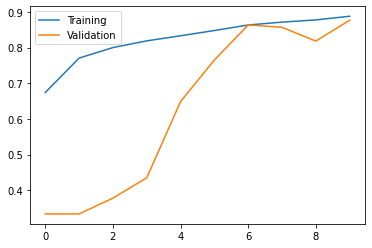

In [10]:
accs= h.history['accuracy']
val_accs= h.history['val_accuracy']
plt.plot(range(len(accs)),accs,label='Training')
plt.plot(range(len(accs)),val_accs,label='Validation')
plt.legend()
plt.show()


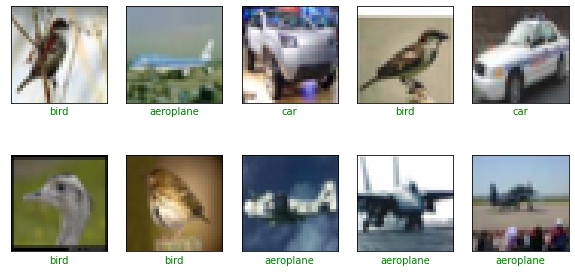

In [15]:
model=tf.keras.models.load_model('models/model_0.877.h5')
preds=model.predict(x_test/255.)
show_random_examples(x_test,y_test,preds)